In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd

from src.tobit import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Randomly generated artificially truncated regression data

In [26]:
rs = np.random.RandomState(seed=10)
ns = 100
nf = 10
x, y_orig, coef = make_regression(n_samples=ns, n_features=nf, coef=True, noise=0.0, random_state=rs)
x = pd.DataFrame(x)
y = pd.Series(y_orig)

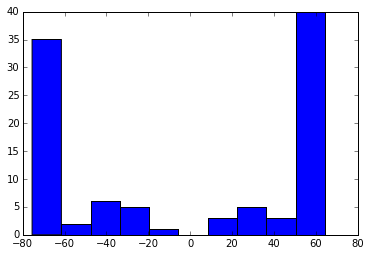

In [29]:
n_quantiles = 3
quantile = 100/float(n_quantiles)
lower = np.percentile(y, quantile)
upper = np.percentile(y, (n_quantiles - 1) * quantile)
left = y < lower
right = y > upper
cens = pd.Series(np.zeros((ns,)))
cens[left] = -1
cens[right] = 1
y = y.clip(upper=upper, lower=lower)
hist = plt.hist(y)

In [40]:
tr = TobitModel()
result = tr.fit(x, y, cens, verbose=False)
print(list(zip(tr.coef_, tr.ols_coef_)))
print("Mean absolute error:", tr.score(x, y_orig))
#print tr.ols_coef_

[(77.940331255409717, 27.856490206519425), (84.727391993504526, 26.071925028137692), (45.85144543444212, 11.460502651708575), (20.490665514239335, 1.4263051015020487), (47.371986285166507, 14.049523968162475), (77.142509442696465, 24.026826810745582), (62.909096264958769, 15.174326843397273), (84.9781848707796, 24.702099116261234), (83.823496094713079, 22.651512683029388), (65.669505122542333, 19.417054142485803)]
Mean absolute error: 1.77777792487e-13


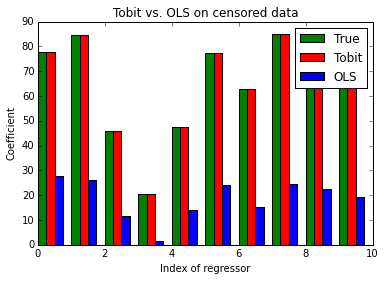

In [49]:
fig, ax = plt.subplots()
ind = np.arange(len(coef))
width = 0.25
rects1 = ax.bar(ind, coef, width, color='g', label='True')
rects2 = ax.bar(ind + width, tr.coef_, width, color='r', label='Tobit')
rects3 = ax.bar(ind + (2 * width), tr.ols_coef_, width, color='b', label='OLS')
plt.ylabel("Coefficient")
plt.xlabel("Index of regressor")
plt.title("Tobit vs. OLS on censored data")
leg = plt.legend()

# Compare to R censReg package result on AER data

In [9]:
# commands in R:
"""
install.packages('censReg')
library(censReg)
install.packages('AER')
data('Affairs', package='AER')
write.table(Affairs, '/cellar/users/jamesdj/Dropbox/frontlet/tobit_data.txt', quote=FALSE, row.names=FALSE)
estResult <- censReg( affairs ~ age + yearsmarried + religiousness +occupation + rating, data = Affairs)
summary(estResult)
"""

"\ninstall.packages('censReg')\nlibrary(censReg)\ninstall.packages('AER')\ndata('Affairs', package='AER')\nwrite.table(Affairs, '/cellar/users/jamesdj/Dropbox/frontlet/tobit_data.txt', quote=FALSE, row.names=FALSE)\nestResult <- censReg( affairs ~ age + yearsmarried + religiousness +occupation + rating, data = Affairs)\nsummary(estResult)\n"

In [11]:
data_file = 'reference/tobit/tobit_data.txt'
df = pd.read_table(data_file, sep=' ')
df.loc[df.gender=='male', 'gender'] = 1
df.loc[df.gender=='female', 'gender'] = 0
df.loc[df.children=='yes', 'children'] = 1
df.loc[df.children=='no', 'children'] = 0
df = df.astype(float)
df.head()

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,1,37,10.00,0,3,18,7,4
1,0,0,27,4.00,0,4,14,6,4
2,0,0,32,15.00,1,1,12,1,4
3,0,1,57,15.00,1,5,18,6,5
4,0,1,22,0.75,0,2,17,6,3


In [12]:
y = df.affairs
x = df.drop(['affairs', 'gender', 'education', 'children'], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts()

-1    451
 0    150
dtype: int64

In [13]:
x.head()

,age,yearsmarried,religiousness,occupation,rating
0,37,10.00,3,7,4
1,27,4.00,4,6,4
2,32,15.00,1,1,4
3,57,15.00,5,6,5
4,22,0.75,2,6,3


In [15]:
tr = TobitModel()
tr.fit(x, y, cens, verbose=False)


In [16]:
tr.coef_

array([-0.17933256,  0.55414179, -1.68622027,  0.32605329, -2.2849727 ])